Entraînement des modèles : Récupération des embeddings pour entraîner les modèles de classification.


Évaluation et sauvegarde du modèle : Évaluation des performances des modèles et conservation du meilleur modèle pour la prédiction future.

In [21]:
import chromadb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score,
    accuracy_score,
    roc_curve, 
    auc,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder


# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Import tain and test

In [9]:

client = chromadb.PersistentClient(path="../chromadb")



# Get collections
train_collection = client.get_collection("airline_sentiment_train")
test_collection = client.get_collection("airline_sentiment_test")

print(f"Train collection: {train_collection.count()} documents")
print(f"Test collection: {test_collection.count()} documents")



# Retrieve all data
train_data = train_collection.get(include=["embeddings", "metadatas"])
test_data = test_collection.get(include=["embeddings", "metadatas"])



# Convert to arrays
X_train = np.array(train_data['embeddings'])
y_train = np.array([meta['label'] for meta in train_data['metadatas']])

X_test = np.array(test_data['embeddings'])
y_test = np.array([meta['label'] for meta in test_data['metadatas']])

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")



# Encode labels as integers for XGBoost and MLP

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


print(f"negative={le.transform(['negative'])[0]}, neutral={le.transform(['neutral'])[0]}, positive={le.transform(['positive'])[0]}")

np.unique(y_train_encoded)

Train collection: 11418 documents
Test collection: 2855 documents

X_train shape: (11418, 384)
X_test shape: (2855, 384)
negative=0, neutral=1, positive=2


array([0, 1, 2])

In [10]:

def plot_confusion_matrix(y_true, y_pred, title, labels=['negative', 'neutral', 'positive']):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_learning_curve(estimator, X, y, title):
    """Plot learning curve"""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_weighted'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
    
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score (Weighted)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_proba, title, classes=['negative', 'neutral', 'positive']):
    """Plot ROC curves for multiclass"""
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = len(classes)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green']
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return roc_auc

---
### class balencing

In [11]:
from sklearn.utils.class_weight import compute_class_weight

import numpy as np

y = np.array(y_train_encoded)  # labels

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)

class_weights

array([0.52460372, 1.60455312, 2.12506979])

---
## Models

### Logtic regresion with
- confusion metric
- learning curve
- loss curve
- auc and roc


Training...

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.81      0.86      1814
     neutral       0.57      0.73      0.64       593
    positive       0.69      0.77      0.72       448

    accuracy                           0.79      2855
   macro avg       0.73      0.77      0.74      2855
weighted avg       0.81      0.79      0.80      2855

Weighted F1-Score: 0.7955


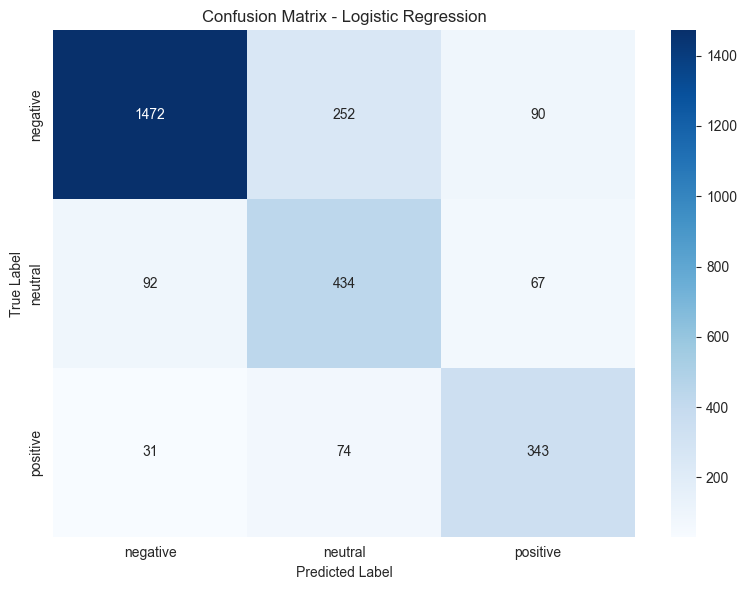


Generating learning curve...


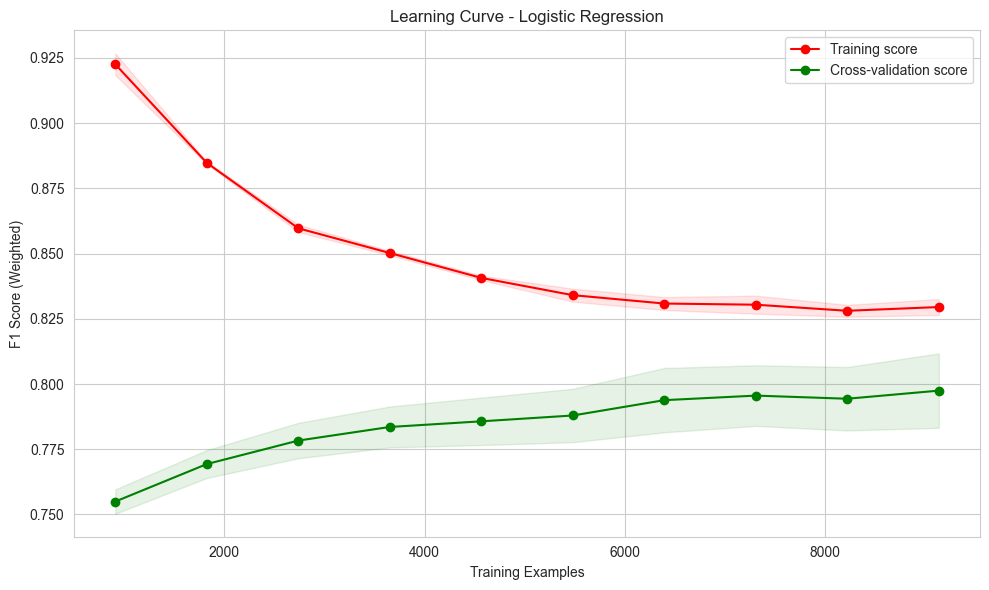

Generating ROC curves...


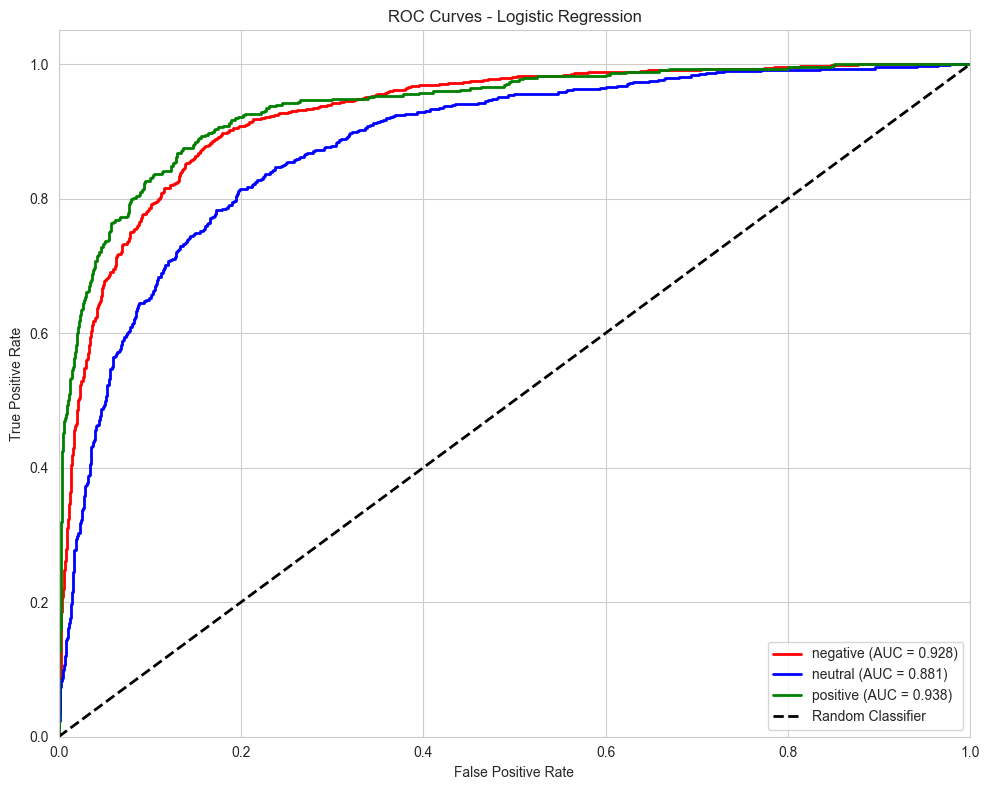

In [12]:

lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced',
    C=1.0
)

print("\nTraining...")
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Weighted F1-Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

# Learning Curve
print("\nGenerating learning curve...")
plot_learning_curve(lr_model, X_train, y_train, "Logistic Regression")

# ROC Curves
print("Generating ROC curves...")
lr_auc = plot_roc_curves(y_test, y_pred_proba_lr, "Logistic Regression")

---
###  RANDOM FOREST 


Training...

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.98      0.84      1814
     neutral       0.72      0.23      0.35       593
    positive       0.83      0.48      0.61       448

    accuracy                           0.74      2855
   macro avg       0.76      0.56      0.60      2855
weighted avg       0.75      0.74      0.70      2855

Weighted F1-Score: 0.7022


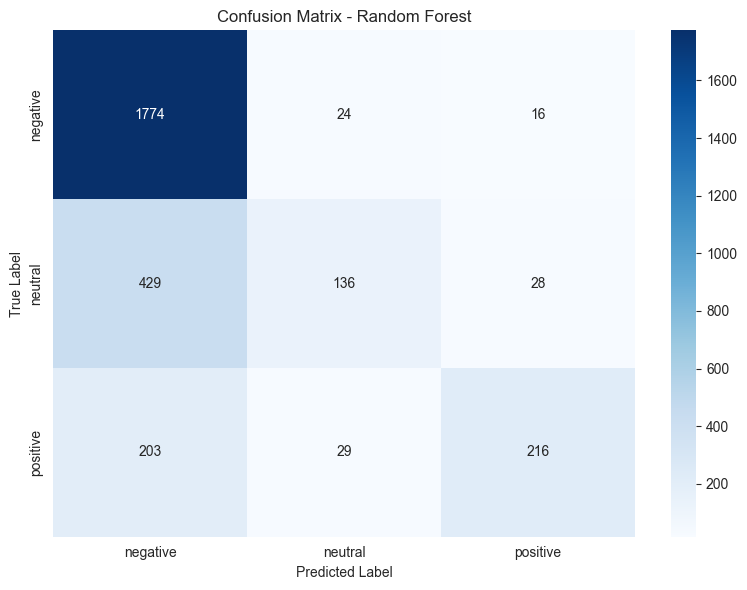


Generating learning curve...


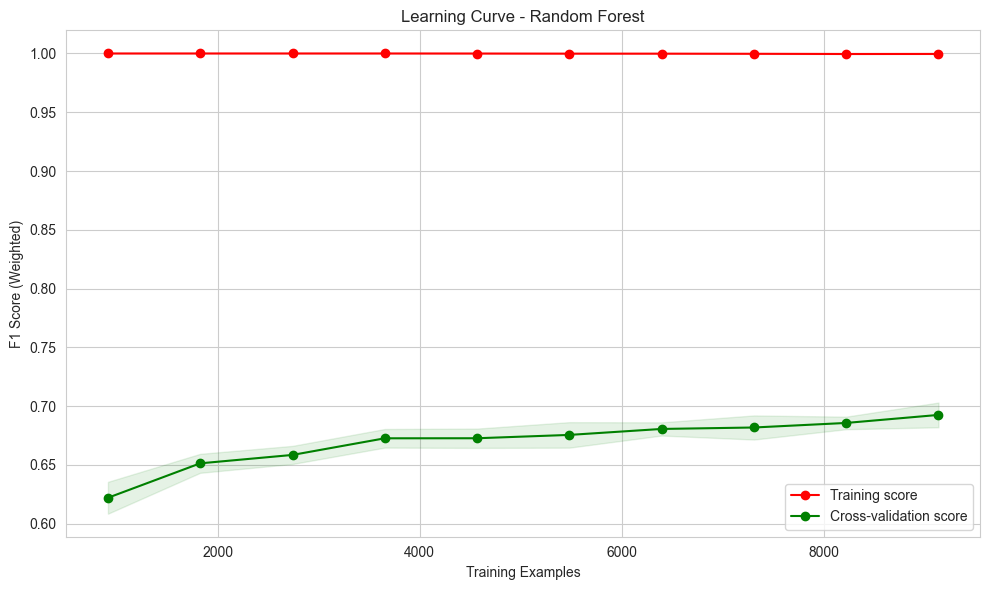

Generating ROC curves...


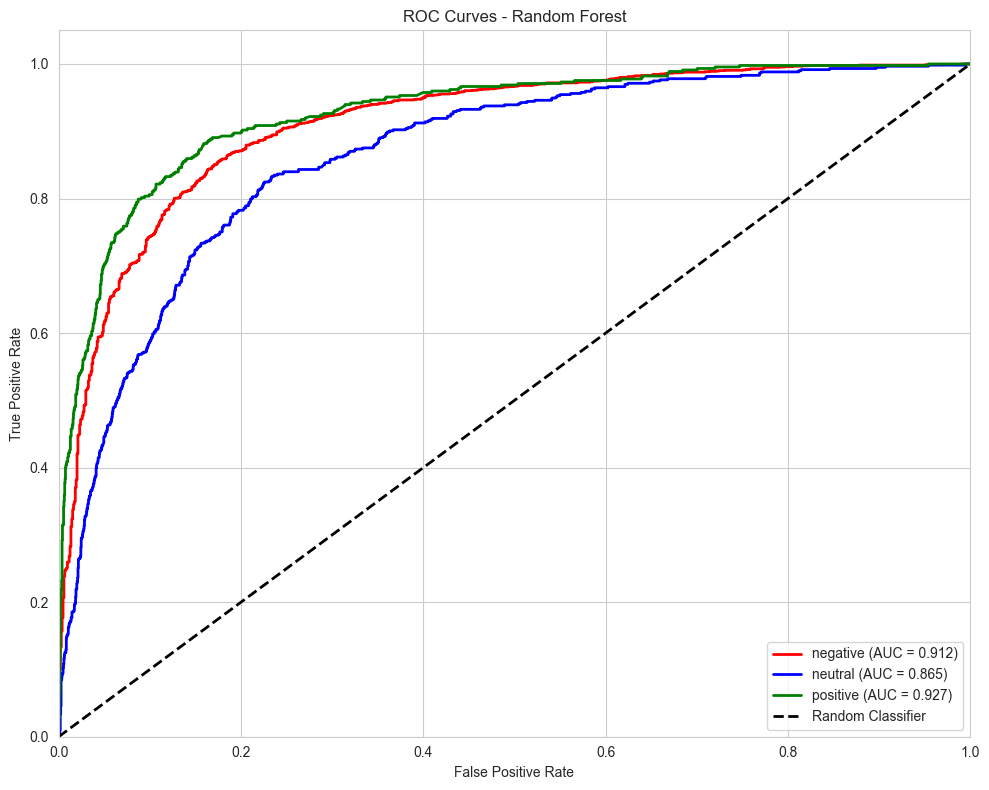

In [13]:

rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced',
    max_depth=20,
    n_jobs=-1
)

print("\nTraining...")
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Weighted F1-Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

# Learning Curve
print("\nGenerating learning curve...")
plot_learning_curve(rf_model, X_train, y_train, "Random Forest")

# ROC Curves
print("Generating ROC curves...")
rf_auc = plot_roc_curves(y_test, y_pred_proba_rf, "Random Forest")


### Xgboost with
- confusion metric
- learning curve
- loss curve
- auc and roc


Training...

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      1814
     neutral       0.63      0.68      0.65       593
    positive       0.75      0.70      0.73       448

    accuracy                           0.81      2855
   macro avg       0.76      0.76      0.76      2855
weighted avg       0.82      0.81      0.82      2855

Weighted F1-Score: 0.8153


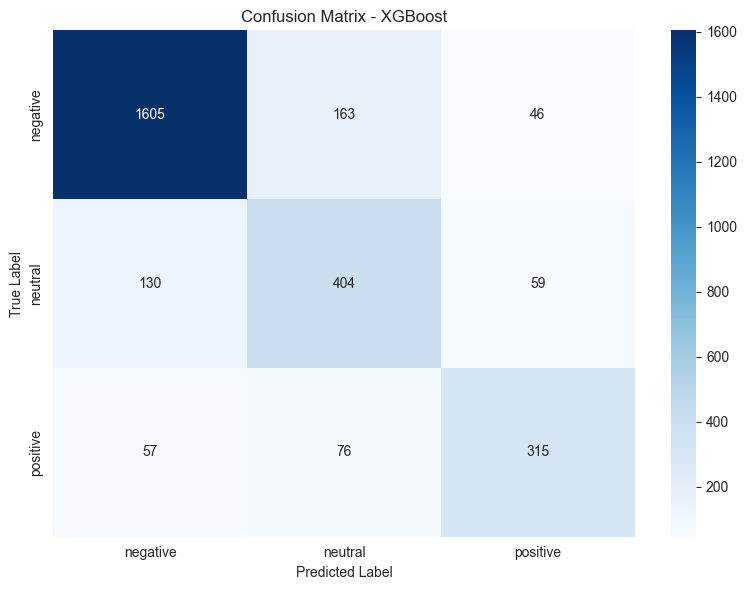


Generating learning curve...


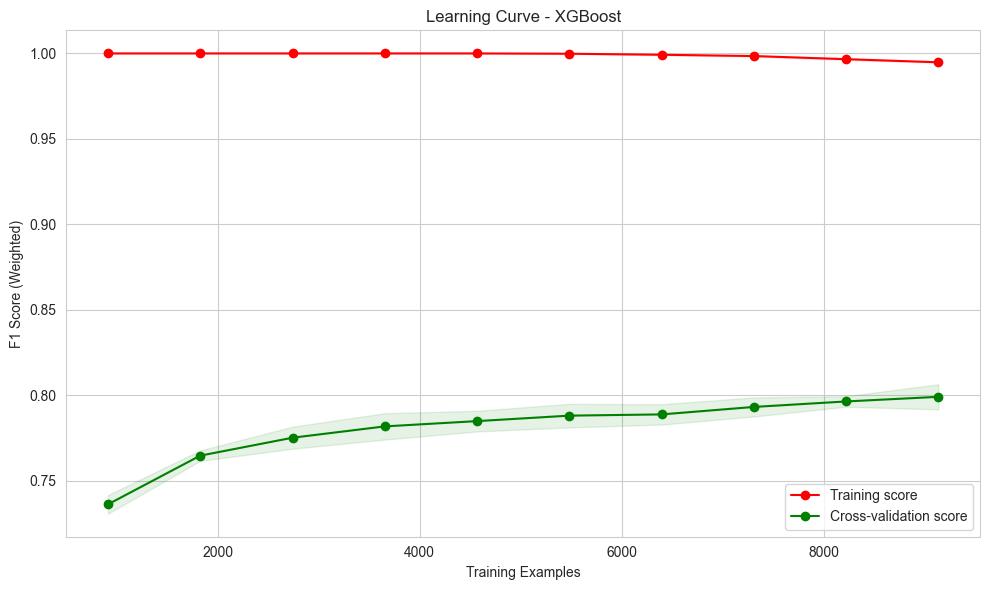

Generating ROC curves...


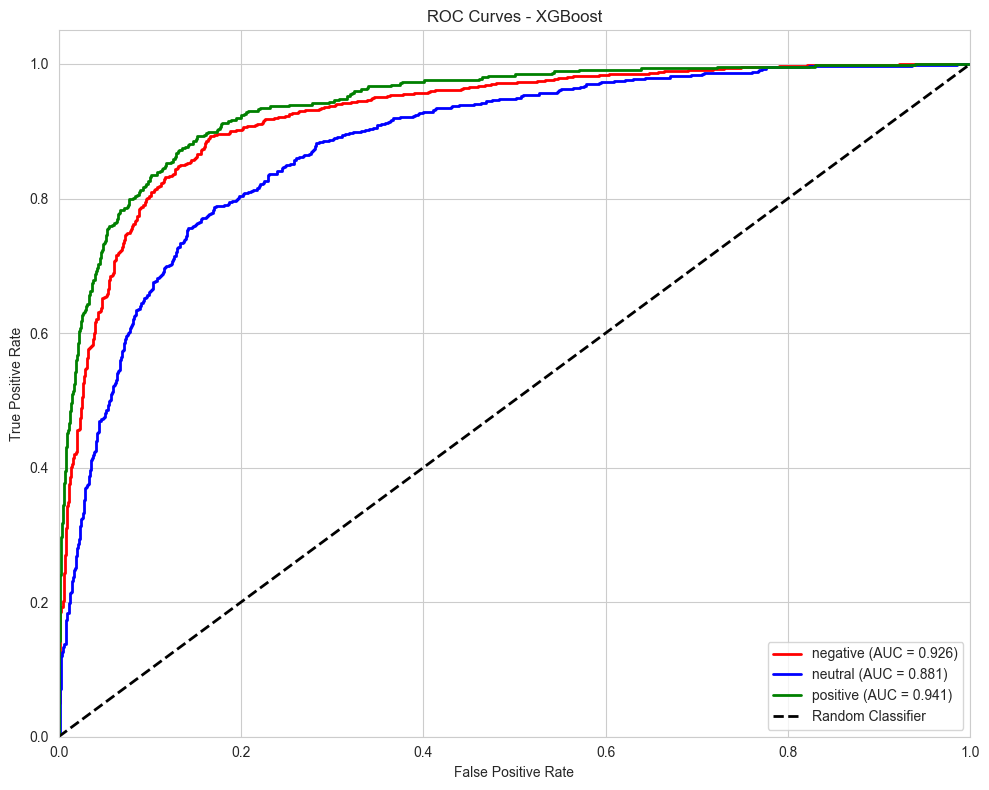

In [17]:


classes = np.unique(y_train_encoded)
# Map class weights to each sample
class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict = np.array([class_weight_dict[y] for y in y_train_encoded])



xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

print("\nTraining...")
xgb_model.fit(X_train, y_train_encoded,sample_weight=class_weight_dict)

# Predictions
y_pred_xgb_encoded = xgb_model.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"Weighted F1-Score: {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

# Learning Curve
print("\nGenerating learning curve...")
plot_learning_curve(xgb_model, X_train, y_train_encoded, "XGBoost")

# ROC Curves
print("Generating ROC curves...")
xgb_auc = plot_roc_curves(y_test, y_pred_proba_xgb, "XGBoost")


### MLP (MULTI-LAYER PERCEPTRON) with
- Confusion matrix 
- learning curve
- loss curve
- auc and roc


Training...

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.84      0.87      1814
     neutral       0.59      0.74      0.66       593
    positive       0.73      0.75      0.74       448

    accuracy                           0.80      2855
   macro avg       0.75      0.77      0.76      2855
weighted avg       0.82      0.80      0.81      2855

Weighted F1-Score: 0.8071


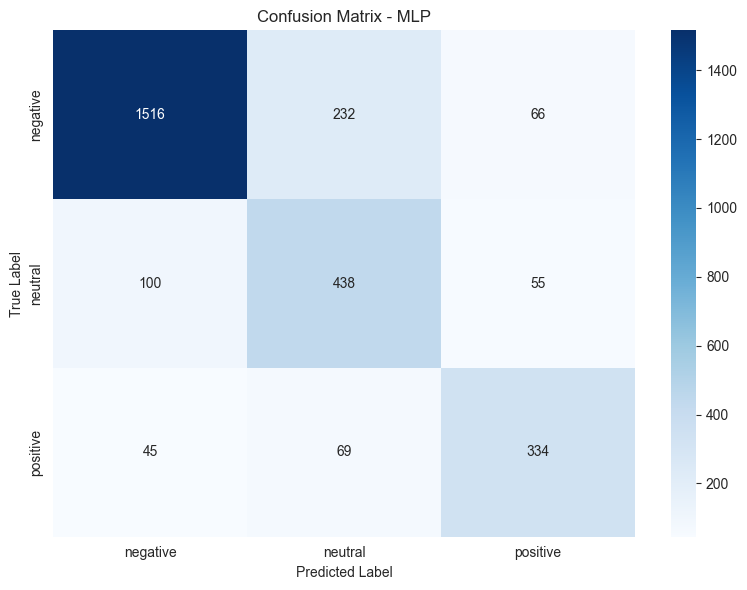

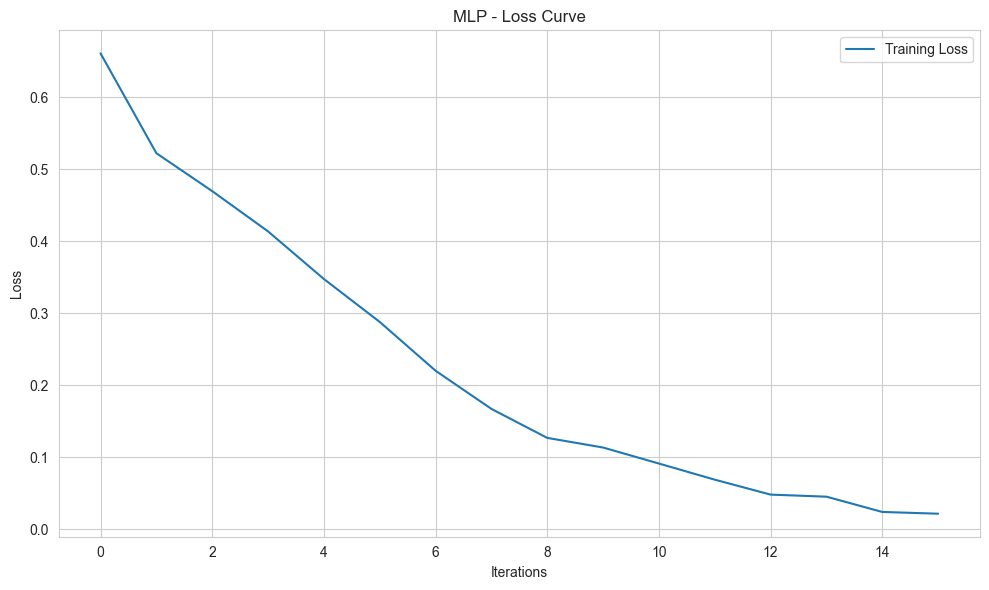

Generating ROC curves...


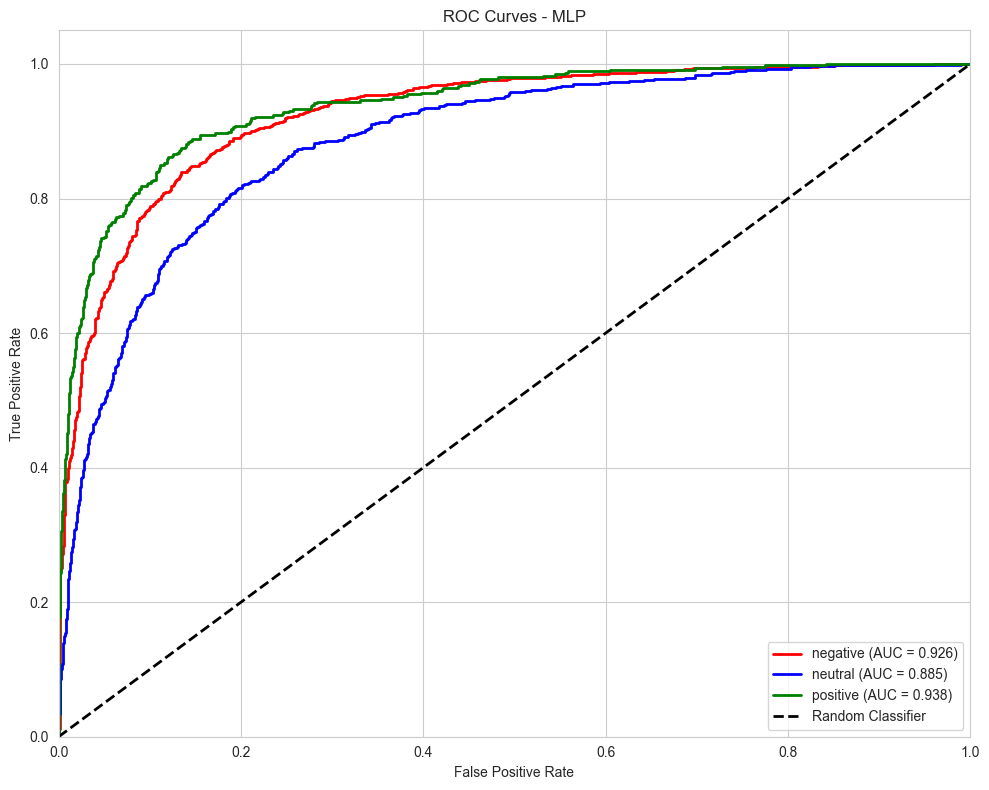

In [19]:

# Use the same label encoder from XGBoost
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=128,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=False
)

# MLPClassifier(
#     hidden_layer_sizes=(128,),
#     max_iter=300,
#     early_stopping=True,
#     alpha=1e-4
# )

# Compute sample weights for each training example
mlp_class_weight_dict = dict(zip(classes, class_weights))
mlp_sample_weights = np.array([mlp_class_weight_dict[y] for y in y_train_encoded])

print("\nTraining...")
mlp_model.fit(X_train, y_train_encoded, sample_weight=mlp_sample_weights)

# Predictions
y_pred_mlp_encoded = mlp_model.predict(X_test)
y_pred_mlp = le.inverse_transform(y_pred_mlp_encoded)
y_pred_proba_mlp = mlp_model.predict_proba(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))
print(f"Weighted F1-Score: {f1_score(y_test, y_pred_mlp, average='weighted'):.4f}")

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred_mlp, "MLP")

# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(mlp_model.loss_curve_, label='Training Loss')
plt.title('MLP - Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC Curves
print("Generating ROC curves...")
mlp_auc = plot_roc_curves(y_test, y_pred_proba_mlp, "MLP")


In [26]:

# Get predictions on training set
y_train_pred_lr = lr_model.predict(X_train)
y_train_pred_rf = rf_model.predict(X_train)
y_train_pred_xgb_encoded = xgb_model.predict(X_train)
y_train_pred_xgb = le.inverse_transform(y_train_pred_xgb_encoded)
y_train_pred_mlp_encoded = mlp_model.predict(X_train)
y_train_pred_mlp = le.inverse_transform(y_train_pred_mlp_encoded)

# Calculate metrics for both train and test
models_comparison = {
    'Logistic Regression': {
        'f1_train': f1_score(y_train, y_train_pred_lr, average='weighted'),
        'f1_test': f1_score(y_test, y_pred_lr, average='weighted'),
        'accuracy_train': accuracy_score(y_train, y_train_pred_lr),
        'accuracy_test': accuracy_score(y_test, y_pred_lr)
    },
    'Random Forest': {
        'f1_train': f1_score(y_train, y_train_pred_rf, average='weighted'),
        'f1_test': f1_score(y_test, y_pred_rf, average='weighted'),
        'accuracy_train': accuracy_score(y_train, y_train_pred_rf),
        'accuracy_test': accuracy_score(y_test, y_pred_rf)
    },
    'XGBoost': {
        'f1_train': f1_score(y_train, y_train_pred_xgb, average='weighted'),
        'f1_test': f1_score(y_test, y_pred_xgb, average='weighted'),
        'accuracy_train': accuracy_score(y_train, y_train_pred_xgb),
        'accuracy_test': accuracy_score(y_test, y_pred_xgb)
    },
    'MLP': {
        'f1_train': f1_score(y_train, y_train_pred_mlp, average='weighted'),
        'f1_test': f1_score(y_test, y_pred_mlp, average='weighted'),
        'accuracy_train': accuracy_score(y_train, y_train_pred_mlp),
        'accuracy_test': accuracy_score(y_test, y_pred_mlp)
    }
}

# Print comparison
print("\n" + "="*80)
print("MODEL COMPARISON - Train vs Test Performance")
print("="*80)
print(f"{'Model':<25} {'F1-Train':>12} {'F1-Test':>12} {'Acc-Train':>12} {'Acc-Test':>12}")
print("-"*80)
for model_name in sorted(models_comparison.keys(), key=lambda x: models_comparison[x]['f1_test'], reverse=True):
    f1_train = models_comparison[model_name]['f1_train']
    f1_test = models_comparison[model_name]['f1_test']
    acc_train = models_comparison[model_name]['accuracy_train']
    acc_test = models_comparison[model_name]['accuracy_test']
    print(f"{model_name:<25} {f1_train:>12.4f} {f1_test:>12.4f} {acc_train:>12.4f} {acc_test:>12.4f}")
print("="*80)

# Calculate overfitting gap
print("\nOverfitting Analysis (Train - Test gap):")
print("-"*80)
print(f"{'Model':<25} {'F1 Gap':>12} {'F1 Gap %':>12} {'Acc Gap':>12} {'Acc Gap %':>12}")
print("-"*80)
for model_name in models_comparison.keys():
    f1_gap = models_comparison[model_name]['f1_train'] - models_comparison[model_name]['f1_test']
    acc_gap = models_comparison[model_name]['accuracy_train'] - models_comparison[model_name]['accuracy_test']
    
    # Calculate gap percentage
    f1_gap_pct = (f1_gap / models_comparison[model_name]['f1_train'] * 100) if models_comparison[model_name]['f1_train'] > 0 else 0
    acc_gap_pct = (acc_gap / models_comparison[model_name]['accuracy_train'] * 100) if models_comparison[model_name]['accuracy_train'] > 0 else 0
    
    print(f"{model_name:<25} {f1_gap:>12.4f} {f1_gap_pct:>11.2f}% {acc_gap:>12.4f} {acc_gap_pct:>11.2f}%")
print("="*80)

# Save best model based on F1-score (test)
best_model_name = max(models_comparison, key=lambda x: models_comparison[x]['f1_test'])
best_models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'MLP': mlp_model
}
best_model = best_models[best_model_name]

os.makedirs("../models", exist_ok=True)

# Save model
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save label encoder if using XGBoost or MLP
if best_model_name in ['XGBoost', 'MLP']:
    with open("../models/label_encoder.pkl", "wb") as f:
        pickle.dump(le, f)

print(f"\n✅ Best model ({best_model_name}) saved to ../models/best_model.pkl")
print(f"   F1-Score (Train): {models_comparison[best_model_name]['f1_train']:.4f}")
print(f"   F1-Score (Test):  {models_comparison[best_model_name]['f1_test']:.4f}")
print(f"   Accuracy (Train): {models_comparison[best_model_name]['accuracy_train']:.4f}")
print(f"   Accuracy (Test):  {models_comparison[best_model_name]['accuracy_test']:.4f}")



MODEL COMPARISON - Train vs Test Performance
Model                         F1-Train      F1-Test    Acc-Train     Acc-Test
--------------------------------------------------------------------------------
XGBoost                         0.9856       0.8153       0.9855       0.8140
MLP                             0.8894       0.8071       0.8867       0.8014
Logistic Regression             0.8272       0.7955       0.8214       0.7877
Random Forest                   0.9996       0.7022       0.9996       0.7447

Overfitting Analysis (Train - Test gap):
--------------------------------------------------------------------------------
Model                           F1 Gap     F1 Gap %      Acc Gap    Acc Gap %
--------------------------------------------------------------------------------
Logistic Regression             0.0317        3.83%       0.0337        4.10%
Random Forest                   0.2974       29.75%       0.2549       25.50%
XGBoost                         0.1703       